In [1]:
import os
os.chdir(os.getcwd())

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('monthly-milk-production.csv')
df.head()

,Month,MilkProduction
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [4]:
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df.set_index('Month',inplace=True)

In [6]:
df.head()

,MilkProduction
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


### Timeseries Decomposition

<AxesSubplot:xlabel='Month'>

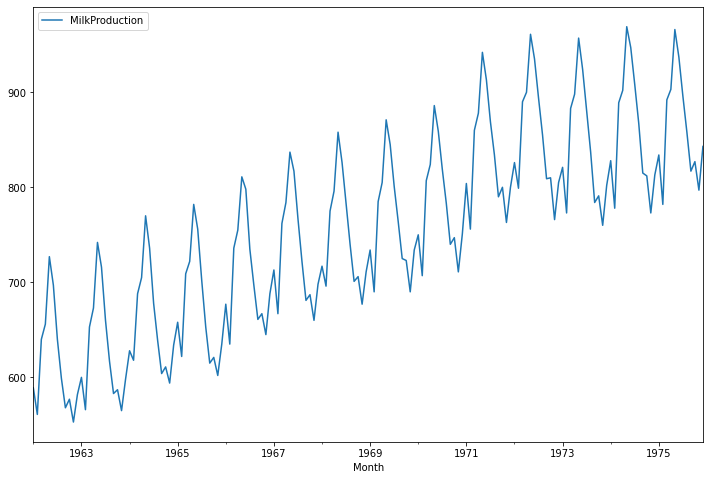

In [7]:
df.plot(figsize=(12,8))

In [8]:
# From the plot above, we can see that seasonal pattern lasts for 12 months (1 year)
seasonal_period = 12

<Figure size 432x288 with 0 Axes>

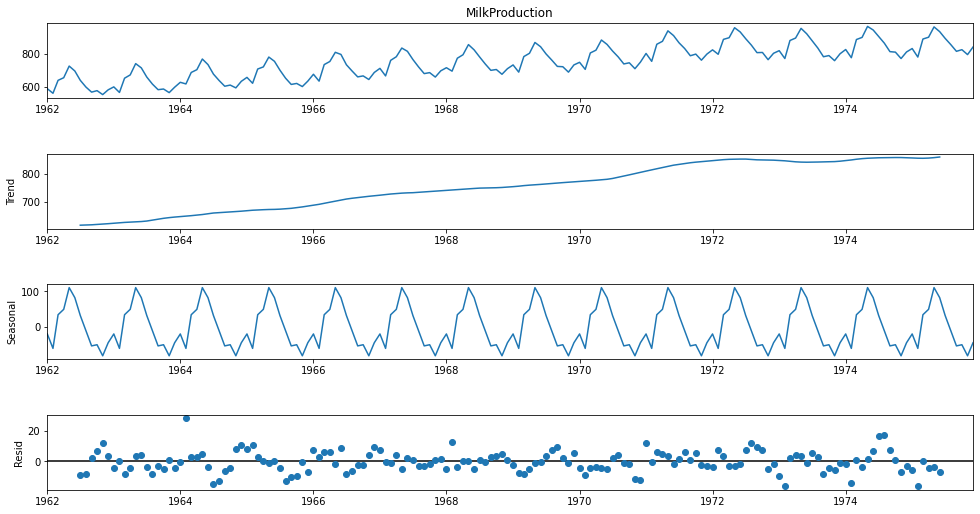

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['MilkProduction'], period=seasonal_period)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Check Stationary, Autocorrelation (ACF), Partial Correlation (PACF)

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['MilkProduction'])
result

(-1.3038115874221314,
 0.6274267086030307,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

In [11]:
def check_adfuller(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Do not reject the null hypothesis. Data is not stationary ")

In [12]:
check_adfuller(df['MilkProduction'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221314
p-value : 0.6274267086030307
#Lags Used : 13
Number of Observations Used : 154
Do not reject the null hypothesis. Data is not stationary 


<AxesSubplot:xlabel='Month'>

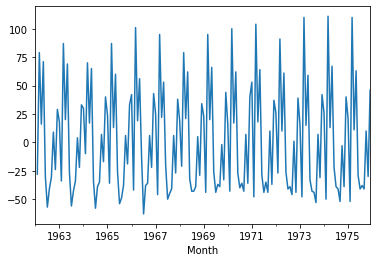

In [13]:
# Since the original timeseries is not stationary, we derive the first-order differenced series
df['First Difference'] = df['MilkProduction'] - df['MilkProduction'].shift(1)
df['First Difference'].plot()

In [14]:
# Check whether the first-order differenced series is stationary
check_adfuller(df['First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586530895
p-value : 0.030068004001784086
#Lags Used : 14
Number of Observations Used : 152
Reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='Month'>

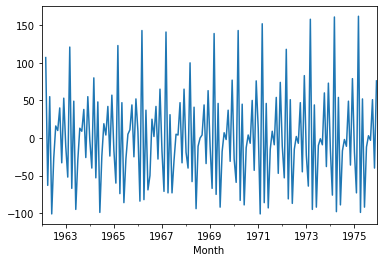

In [15]:
# Although the first-order differenced series is already stationary, 
#          we will check the stationary property of the second-order differenced series
# Derive the second-order differenced series
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)
df['Second Difference'].plot()

In [16]:
# Check whether the second-order differenced series is stationary
check_adfuller(df['Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.327873645603342
p-value : 1.1126989332082822e-26
#Lags Used : 11
Number of Observations Used : 154
Reject the null hypothesis. Data is stationary


In [17]:
# Since the first-order differenced series is stationary, we set difference parameter (d) = 1
d = 1

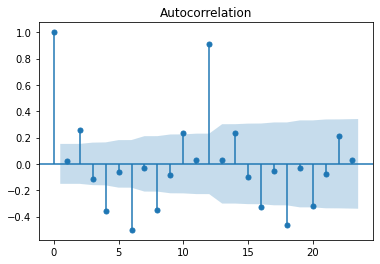

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_first_acf = plot_acf(df["First Difference"].dropna())

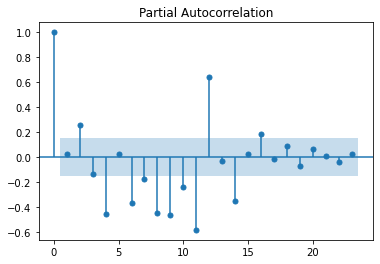

In [19]:
fig_first_pacf = plot_pacf(df["First Difference"].dropna(), method='ywmle')

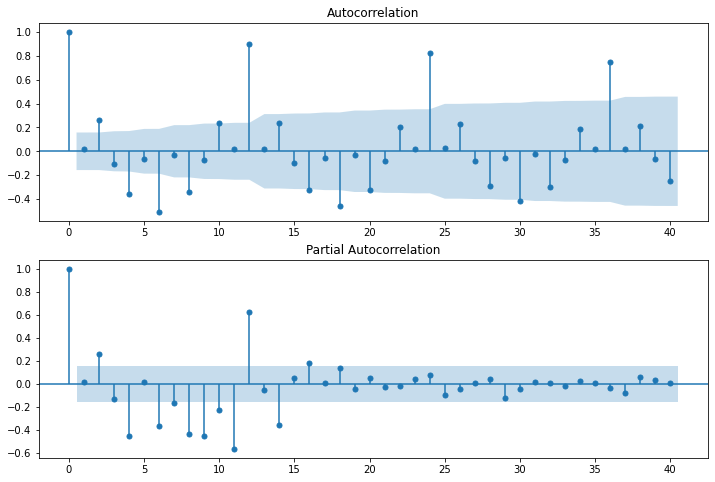

In [20]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['First Difference'].iloc[13:], method='ywmle', lags=40, ax=ax2)

In [21]:
# From ACF and PACF plots of seasonal part of timeseries, we set p = 2, and q = 2
p = 2
q = 2

### Seasonal:  Check Stationary, Autocorrelation (ACF), Partial Correlation (PACF)

<AxesSubplot:xlabel='Month'>

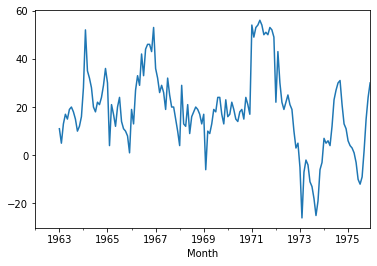

In [22]:
df['Seasonal Difference'] = df['MilkProduction'] - df['MilkProduction'].shift(12)
df['Seasonal Difference'].plot()

In [23]:
check_adfuller(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359397
p-value : 0.16079880527711382
#Lags Used : 12
Number of Observations Used : 143
Do not reject the null hypothesis. Data is not stationary 


<AxesSubplot:xlabel='Month'>

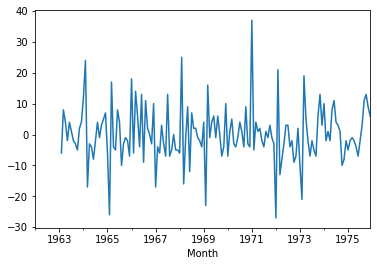

In [24]:
# Since the seasonal part of original timeseries is not stationary, 
#       we derive the first-order difference of seasonal part
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(seasonal_period)
df['Seasonal First Difference'].plot()

In [25]:
# Check whether the first-order difference of seasonal part is stationary or not
check_adfuller(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.03800227492198
p-value : 1.865423431878859e-05
#Lags Used : 11
Number of Observations Used : 143
Reject the null hypothesis. Data is stationary


In [26]:
# Since the first-order difference of seasonal part is stationary, we set seasonal difference parameter (D) = 1
D = 1

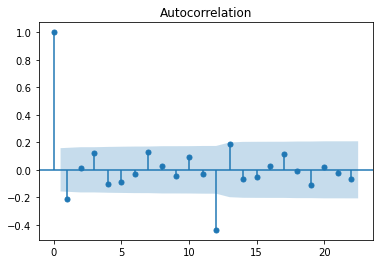

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_seasonal_first_acf = plot_acf(df["Seasonal First Difference"].dropna())

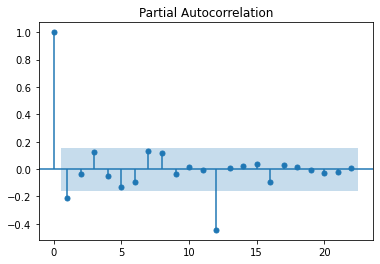

In [28]:
fig_seasonal_first_pacf = plot_pacf(df["Seasonal First Difference"].dropna(), method='ywmle')

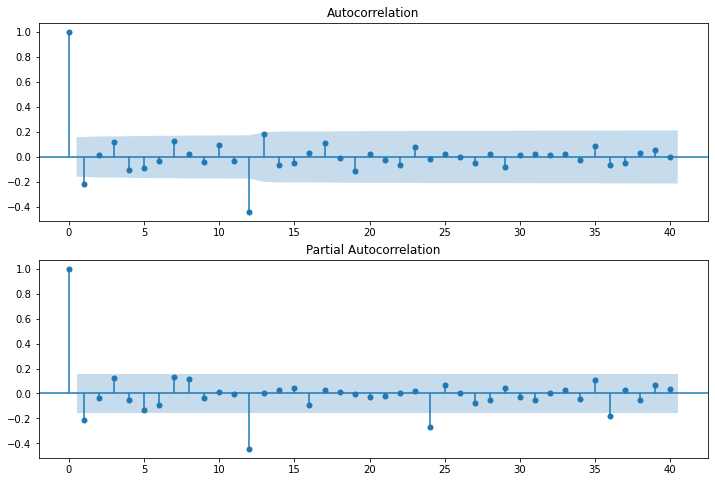

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], method='ywmle', lags=40, ax=ax2)

In [30]:
# From ACF and PACF plots of seasonal part of timeseries, we set P = 1, and Q = 1
P = 1
Q = 1

### ARIMA Model

In [31]:
print(p)
print(d)
print(q)

2
1
2


In [32]:
from statsmodels.tsa.arima.model import ARIMA
# Time index for ARIMA input must have freq parameter set.  
df = df.asfreq(df.index.inferred_freq, method='ffill')
# Run ARIMA 
model = ARIMA(df['MilkProduction'].dropna(), order=(p,d,q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:         MilkProduction   No. Observations:                  168
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -852.823
Date:                Thu, 17 Mar 2022   AIC                           1715.647
Time:                        11:53:09   BIC                           1731.237
Sample:                    01-01-1962   HQIC                          1721.974
                         - 12-01-1975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3263      0.114     -2.854      0.004      -0.550      -0.102
ar.L2         -0.4530      0.140     -3.228      0.001      -0.728      -0.178
ma.L1          0.4045      0.035     11.562      0.0

In [33]:
# Let's try ARIMA with other values of p and q
model2 = ARIMA(df['MilkProduction'].dropna(),order=(1,d,1))
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:         MilkProduction   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -873.508
Date:                Thu, 17 Mar 2022   AIC                           1753.016
Time:                        11:53:09   BIC                           1762.370
Sample:                    01-01-1962   HQIC                          1756.813
                         - 12-01-1975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5097      0.886     -0.575      0.565      -2.247       1.228
ma.L1          0.4528      0.938      0.483      0.629      -1.385       2.291
sigma2      2045.3245    354.835      5.764      0.0

In [34]:
# Let's try ARIMA with other values of p and q
model3 = ARIMA(df['MilkProduction'].dropna(),order=(0,d,0))
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:         MilkProduction   No. Observations:                  168
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -873.866
Date:                Thu, 17 Mar 2022   AIC                           1749.732
Time:                        11:53:09   BIC                           1752.850
Sample:                    01-01-1962   HQIC                          1750.998
                         - 12-01-1975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2054.0918    264.229      7.774      0.000    1536.213    2571.970
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                14.81
Prob(Q):                              0.77   Pr

In [35]:
from statsmodels.tsa.arima_model import ARIMAResults 
model = ARIMA(df['MilkProduction'].dropna(),order=(p,d,q))
result = model.fit()
print(result2.aic)
model2 = ARIMA(df['MilkProduction'].dropna(),order=(0,d,0))
result2 = model2.fit()
print(result2.aic)
model3 = ARIMA(df['MilkProduction'].dropna(),order=(1,d,1))
result3  =model3.fit()
print(result3.aic)
model4 = ARIMA(df['MilkProduction'].dropna(),order=(0,d,1))
result4  =model4.fit()
print(result4.aic)
model5 = ARIMA(df['MilkProduction'].dropna(),order=(1,d,0))
result5  =model5.fit()
print(result5.aic)

1753.0163406744973
1749.7321991329518
1753.0163406744973
1751.6713775108738
1751.6398579071576


### Seasonal ARIMA Model

In [36]:
print(p)
print(d)
print(q)
print(P)
print(D)
print(Q)
print(seasonal_period)

2
1
2
1
1
1
12


In [37]:
from statsmodels.tsa.arima.model import ARIMA
# Time index for ARIMA input must have freq parameter set.  
df = df.asfreq(df.index.inferred_freq, method='ffill')
# Run ARIMA 
model = sm.tsa.statespace.SARIMAX(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(P,D,Q,seasonal_period))
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18315D+00    |proj g|=  3.94458D-02


 This problem is unconstrained.



At iterate    5    f=  3.16117D+00    |proj g|=  5.37575D-02

At iterate   10    f=  3.14781D+00    |proj g|=  1.25875D-02

At iterate   15    f=  3.14729D+00    |proj g|=  6.13573D-03

At iterate   20    f=  3.14710D+00    |proj g|=  6.38555D-03

At iterate   25    f=  3.14704D+00    |proj g|=  2.50105D-04
  ys=-1.635E-06  -gs= 2.659E-05 BFGS update SKIPPED

At iterate   30    f=  3.14504D+00    |proj g|=  2.76971D-02

At iterate   35    f=  3.14353D+00    |proj g|=  1.71353D-03

At iterate   40    f=  3.14352D+00    |proj g|=  1.48369D-04

At iterate   45    f=  3.14352D+00    |proj g|=  5.13145D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

In [38]:
# Let's try SARIMA with other values of p and q
model2 = sm.tsa.statespace.SARIMAX(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(0,D,0,seasonal_period))
result2 = model2.fit()
print(result2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28998D+00    |proj g|=  6.84500D-02

At iterate    5    f=  3.28442D+00    |proj g|=  4.11022D-02

At iterate   10    f=  3.26155D+00    |proj g|=  2.47526D-02


 This problem is unconstrained.



At iterate   15    f=  3.26010D+00    |proj g|=  3.96159D-03

At iterate   20    f=  3.26004D+00    |proj g|=  2.68749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   4.406D-05   3.260D+00
  F =   3.2600391549314427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                      
Dep. Variable:                      MilkProduction   No. Observations:                  168
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                -547.687
Date:                  

In [39]:
from statsmodels.tsa.arima_model import ARIMAResults 
model2 = ARIMA(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(P,D,Q,seasonal_period))
result2 = model2.fit()
print(result2.aic)
model2 = ARIMA(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(0,D,0,seasonal_period))
result2 = model2.fit()
print(result2.aic)
model3 = ARIMA(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(0,D,1,seasonal_period))
result3  =model3.fit()
print(result3.aic)
model4 = ARIMA(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(1,D,0,seasonal_period))
result4  =model4.fit()
print(result4.aic)
model5 = ARIMA(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(1,D,1,seasonal_period))
result5  =model5.fit()
print(result5.aic)

1070.2221284112493
1105.3731560569647
1068.466615179292
1083.5579813195327
1070.2221284112493


<AxesSubplot:xlabel='Month'>

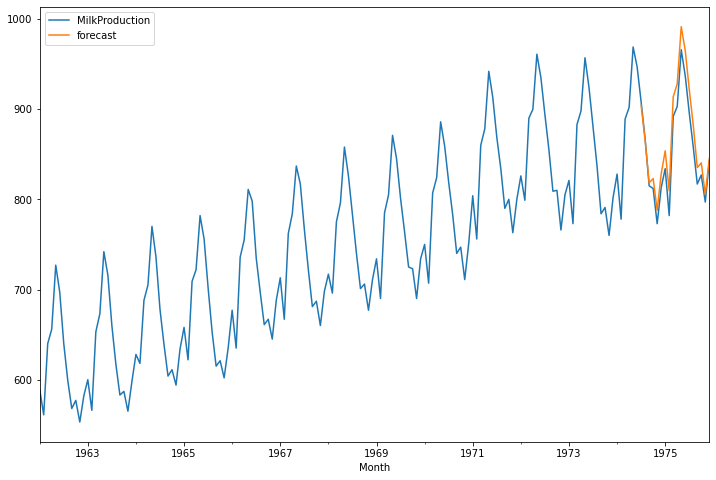

In [40]:
model3 = ARIMA(df['MilkProduction'].dropna(),order=(p,d,q), seasonal_order=(0,D,1,seasonal_period))
result3  =model3.fit()
df['forecast'] = result3.predict(start = 150, end= 168, dynamic= True)  
df[['MilkProduction','forecast']].plot(figsize=(12,8))

In [41]:
# predict monthly value for 2 years after 1975
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24)]
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [42]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df = pd.concat([df,future_dates_df])
future_df.tail()

,MilkProduction,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

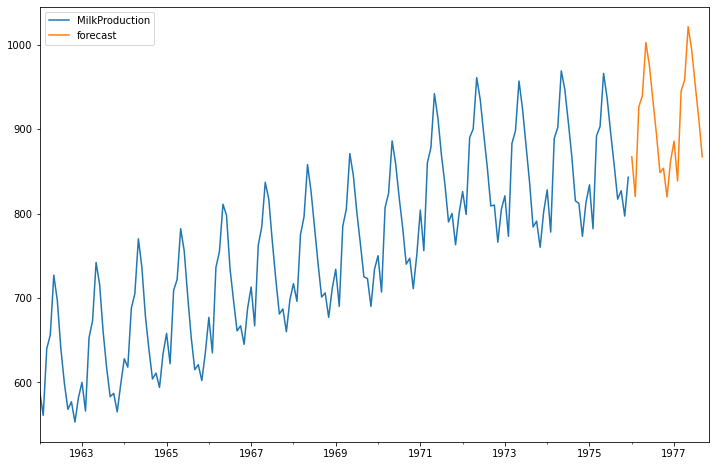

In [43]:
future_df['forecast'] = result3.predict(start = 168, end = 188, dynamic= True)  
future_df[['MilkProduction', 'forecast']].plot(figsize=(12, 8)) 

<AxesSubplot:xlabel='Month'>

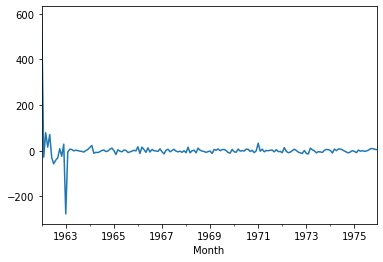

In [44]:
result3.resid.plot()